## Análisis estadístico de los datos

### Importación de librerías y del dataset

In [6]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("../data/output/basededatos_limpia.csv")

print("Filas y columnas:", df.shape)
df.head()

Filas y columnas: (51290, 25)


,order_id,order_date,ship_date,ship_mode,customer_name,segment,state,country,market,region,...,quantity,discount,profit,shipping_cost,order_priority,year,admin_name,latitud,longitud,poblacion
0,AG-2011-2040,2011-01-01,2011-06-01,Standard Class,Toby Braunhardt,Consumer,constantine,algeria,Africa,Africa,...,2,0.0,106.140,35.46,Medium,2011,constantine,36.355089,6.664344,878977.0
1,IN-2011-47883,2011-01-01,2011-08-01,Standard Class,Joseph Holt,Consumer,new south wales,australia,APAC,Oceania,...,3,0.1,36.036,9.72,Medium,2011,new south wales,-32.646250,150.196007,6379411.0
2,HU-2011-1220,2011-01-01,2011-05-01,Second Class,Annie Thurman,Consumer,budapest,hungary,EMEA,EMEA,...,4,0.0,29.640,8.17,High,2011,budapest,47.498300,19.040800,1686222.0
3,IT-2011-3647632,2011-01-01,2011-05-01,Second Class,Eugene Moren,Home Office,stockholm,sweden,EU,North,...,3,0.5,-26.055,4.82,High,2011,stockholm,59.376200,18.033443,1652923.0
4,IN-2011-47883,2011-01-01,2011-08-01,Standard Class,Joseph Holt,Consumer,new south wales,australia,APAC,Oceania,...,5,0.1,37.770,4.70,Medium,2011,new south wales,-32.646250,150.196007,6379411.0


Realizamos este análisis para probar si hay diferencias significativas o relaciones entre variables de la base de datos.

Verificación que las columnas clave están presentes:

In [7]:
df.columns.tolist()

['order_id',
 'order_date',
 'ship_date',
 'ship_mode',
 'customer_name',
 'segment',
 'state',
 'country',
 'market',
 'region',
 'product_id',
 'category',
 'sub_category',
 'product_name',
 'sales',
 'quantity',
 'discount',
 'profit',
 'shipping_cost',
 'order_priority',
 'year',
 'admin_name',
 'latitud',
 'longitud',
 'poblacion']

### Prueba T-test (prueba de diferencia a de medias entre dos grupos)

Usamos el T-test para comparar medias. Por ejemplo, ¿el beneficio medio ``profit`` cambia según el ``modo de envío``?

Hipótesis:

H0 (nula): No hay diferencia en el beneficio medio entre modos de envío.

H1 (alternativa): Sí hay diferencia.

In [10]:
# Creamos dos grupos: Standard Class vs Second Class
grupo1 = df[df["ship_mode"].str.lower() == "standard class"]["profit"].dropna()
grupo2 = df[df["ship_mode"].str.lower() == "second class"]["profit"].dropna()

# Aplicamos T-test (no asumimos varianzas iguales)
t_stat, p_valor_ttest = stats.ttest_ind(grupo1, grupo2, equal_var=False)

print("T-test (beneficio por tipo de envío)")
print("Estadístico t:", round(t_stat, 3))
print("p-valor:", round(p_valor_ttest, 5))

T-test (beneficio por tipo de envío)
Estadístico t: 0.214
p-valor: 0.83052


Como el p-valor es ≥ 0.05, no hay diferencia significativa entre las variables, por lo que los beneficios medios son similares (aceptamos la hipótesis nula).

Visualización con un boxplot:

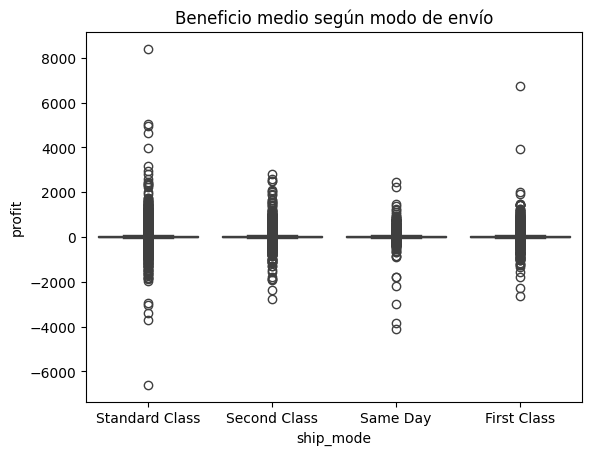

In [9]:
sns.boxplot(x="ship_mode", y="profit", data=df)
plt.title("Beneficio medio según modo de envío")
plt.show()

### Prueba ANOVA (comparar medias entre más de dos grupos)

Ahora vamos a analizar si las ventas medias ``sales`` difieren entre las distintas ``regiones``.

Hipótesis:

H0 (nula): Todas las regiones tienen la misma media de ventas.

H1 (alternativa): Al menos una región tiene una media diferente.

In [11]:
# Creamos grupos por región
grupos = [g["sales"].dropna() for _, g in df.groupby("region")]

# ANOVA
f_stat, p_valor_anova = stats.f_oneway(*grupos)

print("ANOVA (ventas por región)")
print("Estadístico F:", round(f_stat, 3))
print("p-valor:", round(p_valor_anova, 5))


ANOVA (ventas por región)
Estadístico F: 60.608
p-valor: 0.0


Como el p-valor es < 0.05, hay diferencias significativas en las ventas medias entre regiones (rechazamos hipótesis nula).

Visualización con un boxplot:

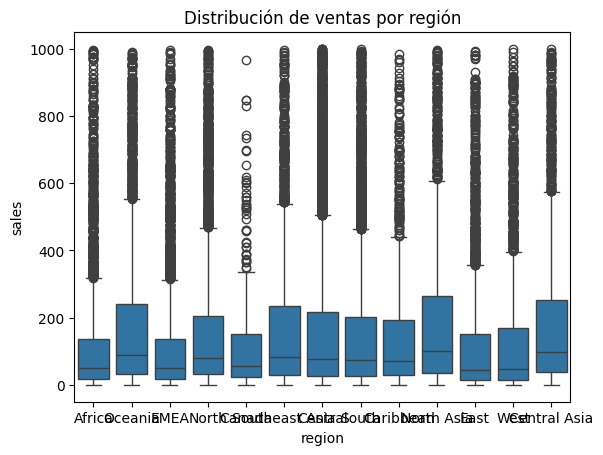

In [12]:
sns.boxplot(x="region", y="sales", data=df)
plt.title("Distribución de ventas por región")
plt.show()

### Prueba Chi-cuadrado (relación entre variables categóricas)

Comprobamos a ver si existe relación entre el ``segmento`` del cliente y la ``prioridad del pedido``.

Hipótesis:

H0:(nula) Las variables son independientes (no hay relación).

H1 (alternativa): Las variables están relacionadas.

In [13]:
# Tabla de contingencia
tabla = pd.crosstab(df["segment"], df["order_priority"])

# Chi-cuadrado
chi2, p_valor_chi2, dof, expected = stats.chi2_contingency(tabla)

print("Chi-cuadrado (segmento vs prioridad de pedido)")
print("Chi2:", round(chi2, 3))
print("p-valor:", round(p_valor_chi2, 5))

Chi-cuadrado (segmento vs prioridad de pedido)
Chi2: 44.95
p-valor: 0.0


Como el p-valor es < 0.05, las variables están relacionadas, por lo que hay relación entre segmento y prioridad del pedido (rechazamos la hipótesis nula).

Visualización con un mapa de calor:

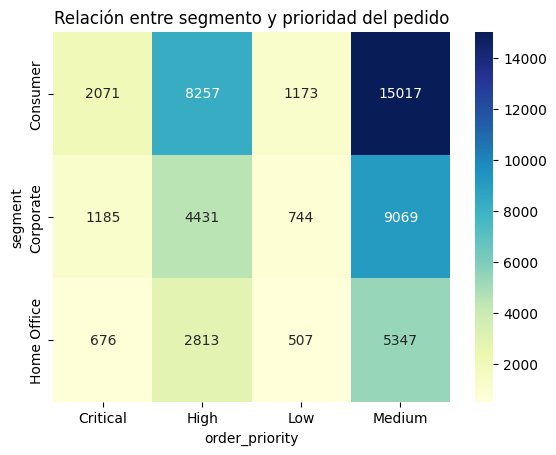

In [14]:
sns.heatmap(tabla, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Relación entre segmento y prioridad del pedido")
plt.show()

### Prueba Correlación (relación entre variables numéricas)

Finalmente, vemos si existe relación entre ``ventas``, ``descuento``, ``beneficio``, ``coste de envío`` y ``cantidad``.

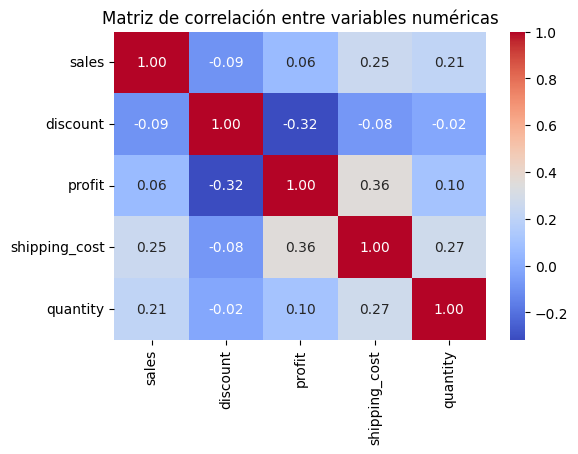

In [15]:
corr = df[["sales", "discount", "profit", "shipping_cost", "quantity"]].corr()

plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlación entre variables numéricas")
plt.show()

Se observa que el descuento está negativamente relacionado con el beneficio, lo que significa que cuanto más descuento menos beneficio lo cual es lógico.